In [74]:
# 目的: 調閱並生成特定ID tif檔案的每一層2D圖片、影片(包含切割結果)

In [75]:
# Step1 輸入本次要調閱的特定ID
# Gad1-F-200010 、fru-F-500182 是離群值之一 、 npf-F-100007 這是成功的、 E0585-F-100023 這是成功的
# 隨機抽取區間兩個大腦
# 10~20區間: TH-F-300011 、 fru-F-600276(完成)
# 20~30區間: Gad1-F-600148 、 Gad1-F-500172(完成)
# 30~40區間: VGlut-F-100027 、 fru-F-600152(完成)
# 30~40區間: E0585-F-200000 、 E0585-F-200001(完成)
# 50~61區間: npf-F-100007 、 E0585-F-100023(完成)
# 總共會有11個不重複大腦( 2個離群、9個正常) 1個有重複
Brain_ID_Target = 'E0585-F-200000'

已經提取到 1 個檔案的SEG路徑
請將提取到的數字和上面分布圖的統計數字比對是否相等


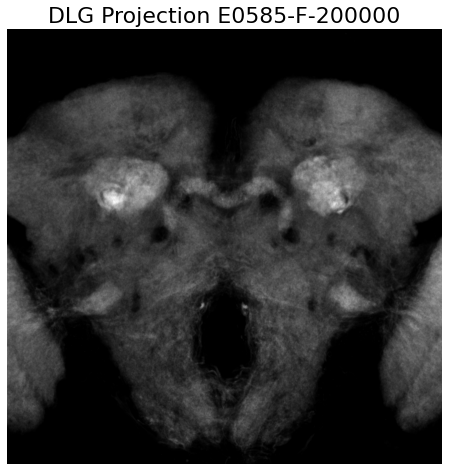

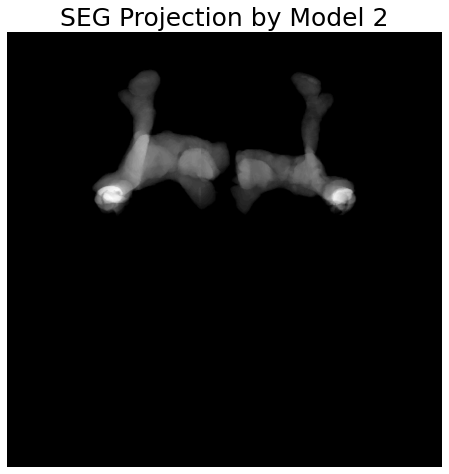

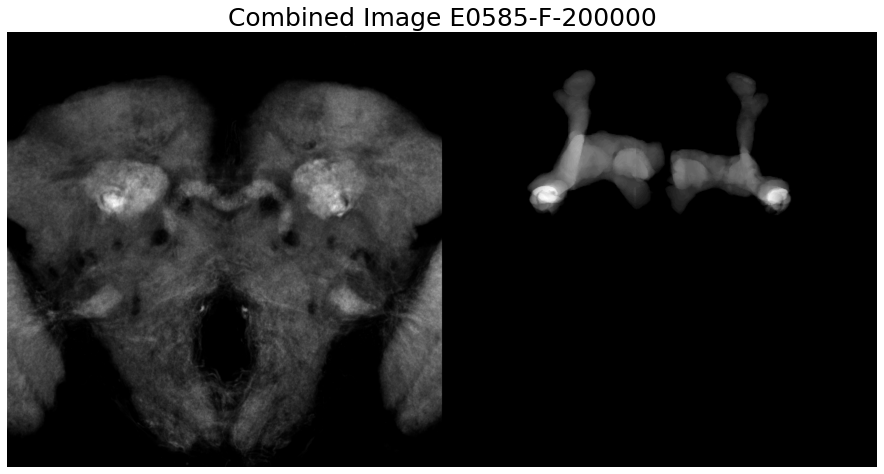

In [76]:
# Step2 讀取Model 2的切割圖
# 可以人工檢查特定ID大腦的圖片 ============呈現Model2的切割圖
import os
import tifffile as tif
import matplotlib.pyplot as plt
import cv2
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'
# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()

stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容_完成放回原始影像_客製化數據集')]

# 找到原始DLG和對應的Seg
# 手動輸入要讀取的大腦編號 # Seg_MB_npf-F-100007 、 Seg_MB_E0585-F-100023
three_brains_names = ['Seg_MB_'+Brain_ID_Target]

# 用於存儲檔案路徑的字典
file_paths = {}

# 遍歷檔案名稱列表
for file_name in three_brains_names:
    # filename 沒有包含附檔案名稱
    file_name_with_tif = file_name+'.tif'
    found = False
    # 對每個檔案名稱，檢查所有資料夾
    for folder in stage_five_folders:
        potential_path = os.path.join(nas_path, folder, file_name_with_tif)
        # 檢查檔案是否存在於當前資料夾
        if os.path.exists(potential_path):
            file_paths[file_name] = potential_path
            found = True
            break

# # 打印結果或進行後續處理
# for file_name, path in file_paths.items():
#     print(f"{file_name}: {path}")
# 已經提取到 758個檔案的SEG路徑
print('已經提取到',len(three_brains_names),'個檔案的SEG路徑')
print('請將提取到的數字和上面分布圖的統計數字比對是否相等')

# 顯示三張合併的2D圖片
import numpy as np
import os
from PIL import Image
import tifffile as tif
import time  # 導入 time 模塊
# 确保在 notebook 中嵌入图像
%matplotlib inline
def normalize_image(image):
    """
    归一化图像到0到255的范围。
    """
    # 计算图像的最大值和最小值
    min_val = np.min(image)
    max_val = np.max(image)
    # 归一化到0-1
    normalized_image = (image - min_val) / (max_val - min_val)
    # 缩放到0-255并转换为整数
    scaled_image = (normalized_image * 255).astype(np.uint8)
    return scaled_image
start_time = time.time()  # 記錄迴圈開始的時間
for file_name in three_brains_names:
    seg_path = file_paths[file_name]
    # 將Seg路徑替換為DLG路徑
    dlg_path = seg_path.replace('Seg_MB', 'DLG')
    
    # 讀取圖像
    dlg_image = tif.imread(dlg_path)
    seg_image = tif.imread(seg_path)
    
    # 投影和归一化图像
    dlg_projection = np.sum(dlg_image[:len(dlg_image)//3, :, :], axis=0)
    seg_projection = np.sum(seg_image, axis=0)
    
    dlg_projection_normalized = normalize_image(dlg_projection)
    seg_projection_normalized = normalize_image(seg_projection)
    # 合并图像
    combined_image = np.concatenate((dlg_projection_normalized, seg_projection_normalized), axis=1)
    # 显示 dlg_projection_normalized 图像
    plt.figure(figsize=(8, 8))
    plt.imshow(dlg_projection_normalized, cmap='gray')
    plt.title("DLG Projection "+seg_path.split('_')[-1].split('.')[0],size=22)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 seg_projection_normalized 图像
    plt.figure(figsize=(8, 8))
    plt.imshow(seg_projection_normalized, cmap='gray')
#     plt.title("SEG Projection "+seg_path.split('_')[-1].split('.')[0]+'by Model 2',size=25)
    plt.title("SEG Projection "+'by Model 2',size=25)

    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 combined_image 图像
    plt.figure(figsize=(16, 8))
    plt.imshow(combined_image, cmap='gray')
    plt.title("Combined Image "+seg_path.split('_')[-1].split('.')[0],size=25)
    plt.axis('off')  # 不显示坐标轴
    plt.show()


In [77]:
# Step3 將Model 2切割結果變成邊界列表(後續作圖用)
LABEL2 = seg_image.copy()
# Step2 將本次的人工標記變成邊界
# 繪製邊界: Label_boundary_list
Label_boundary_list2 = []
for i in range(len(LABEL2)):
    img = (LABEL2[i]/np.max(LABEL2[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    Label_boundary_list2.append(Final_img)# 先將邊界新增至 Label_boundary_list
Label_boundary_list2 = np.array(Label_boundary_list2)


/tmp/ipykernel_4030459/3452029291.py:7: RuntimeWarning: invalid value encountered in true_divide
  img = (LABEL2[i]/np.max(LABEL2[i])*255).astype(np.uint8)


已經提取到 1 個檔案的SEG路徑
請將提取到的數字和上面分布圖的統計數字比對是否相等


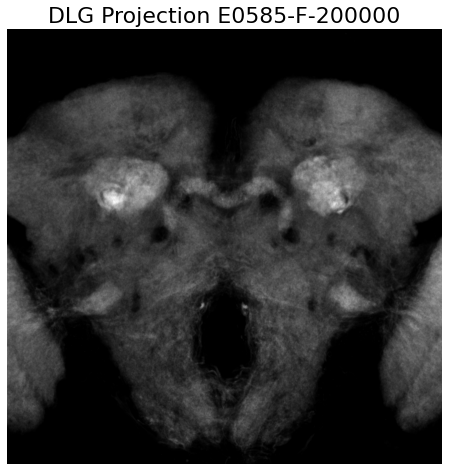

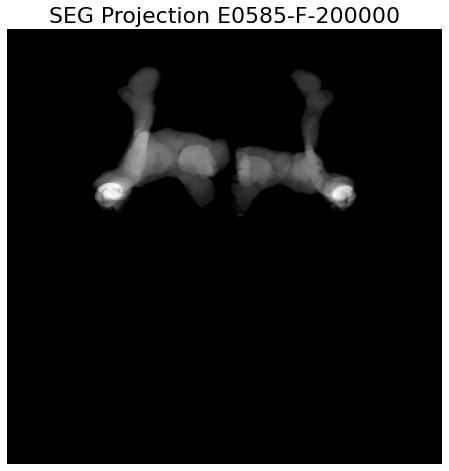

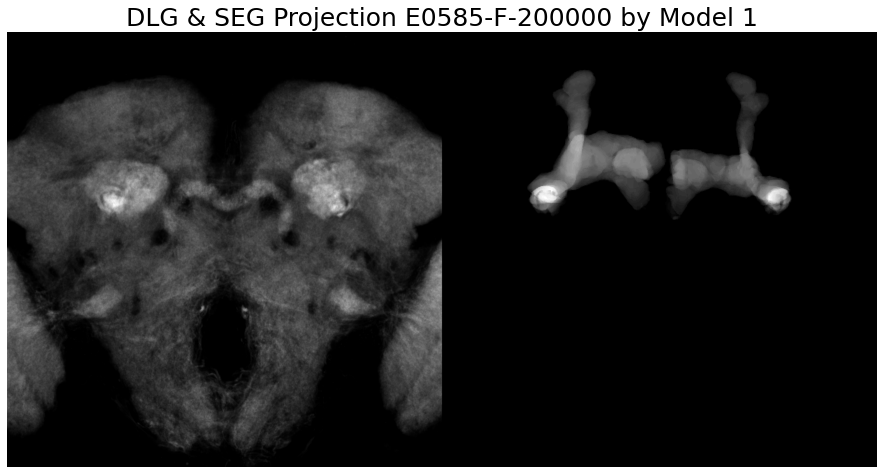

In [78]:
# Step4 讀取Model 1的切割圖

# 可以人工檢查特定ID大腦的圖片 ============呈現Model1的切割圖
import os
import tifffile as tif
nas_path = '/mnt/nas_1/LoLab/kaiyi_hsu/LYNSU/'
# 列出指定路徑下所有項目
all_folder_list = os.listdir(nas_path)
all_folder_list.sort()

stage_five_folders = [folder for folder in all_folder_list if folder.startswith('使用者程序_第五階段存檔內容_完成放回原始影像_母果蠅')]

# 找到原始DLG和對應的Seg
# 手動輸入要讀取的大腦編號
# 手動輸入要讀取的大腦編號 # Seg_MB_npf-F-100007 、 Seg_MB_E0585-F-100023
three_brains_names = ['Seg_MB_'+Brain_ID_Target]

# 用於存儲檔案路徑的字典
file_paths = {}

# 遍歷檔案名稱列表
for file_name in three_brains_names:
    # filename 沒有包含附檔案名稱
    file_name_with_tif = file_name+'.tif'
    found = False
    # 對每個檔案名稱，檢查所有資料夾
    for folder in stage_five_folders:
        potential_path = os.path.join(nas_path, folder, file_name_with_tif)
        # 檢查檔案是否存在於當前資料夾
        if os.path.exists(potential_path):
            file_paths[file_name] = potential_path
            found = True
            break

# # 打印結果或進行後續處理
# for file_name, path in file_paths.items():
#     print(f"{file_name}: {path}")
# 已經提取到 758個檔案的SEG路徑
print('已經提取到',len(three_brains_names),'個檔案的SEG路徑')
print('請將提取到的數字和上面分布圖的統計數字比對是否相等')

# 顯示三張合併的2D圖片
import numpy as np
import os
from PIL import Image
import tifffile as tif
import time  # 導入 time 模塊
# 确保在 notebook 中嵌入图像
%matplotlib inline
def normalize_image(image):
    """
    归一化图像到0到255的范围。
    """
    # 计算图像的最大值和最小值
    min_val = np.min(image)
    max_val = np.max(image)
    # 归一化到0-1
    normalized_image = (image - min_val) / (max_val - min_val)
    # 缩放到0-255并转换为整数
    scaled_image = (normalized_image * 255).astype(np.uint8)
    return scaled_image
start_time = time.time()  # 記錄迴圈開始的時間
for file_name in three_brains_names:
    seg_path = file_paths[file_name]
    # 將Seg路徑替換為DLG路徑
    dlg_path = seg_path.replace('Seg_MB', 'DLG')
    
    # 讀取圖像
    dlg_image = tif.imread(dlg_path)
    seg_image = tif.imread(seg_path)
    
    # 投影和归一化图像
    dlg_projection = np.sum(dlg_image[:len(dlg_image)//3, :, :], axis=0)
    seg_projection = np.sum(seg_image, axis=0)
    
    dlg_projection_normalized = normalize_image(dlg_projection)
    seg_projection_normalized = normalize_image(seg_projection)
    # 合并图像
    combined_image = np.concatenate((dlg_projection_normalized, seg_projection_normalized), axis=1)
    # 显示 dlg_projection_normalized 图像
    plt.figure(figsize=(8, 8))
    plt.imshow(dlg_projection_normalized, cmap='gray')
    plt.title("DLG Projection "+seg_path.split('_')[-1].split('.')[0],size=22)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 seg_projection_normalized 图像
    plt.figure(figsize=(8, 8))
    plt.imshow(seg_projection_normalized, cmap='gray')
    plt.title("SEG Projection "+seg_path.split('_')[-1].split('.')[0],size=22)
    plt.axis('off')  # 不显示坐标轴
    plt.show()

    # 显示 combined_image 图像
    plt.figure(figsize=(16, 8))
    plt.imshow(combined_image, cmap='gray')
    plt.title("DLG & SEG Projection "+seg_path.split('_')[-1].split('.')[0]+' by Model 1',size=25)
    plt.axis('off')  # 不显示坐标轴
    plt.show()


In [79]:
# Step5 將Model 1切割結果變成邊界列表(後續作圖用)

LABEL1 = seg_image.copy()
# Step2 將本次的人工標記變成邊界
# 繪製邊界: Label_boundary_list
Label_boundary_list1 = []
for i in range(len(LABEL1)):
    img = (LABEL1[i]/np.max(LABEL1[i])*255).astype(np.uint8)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)# 原本的圖片是灰階，要轉成BGR
    # 提供給刪除用
    img_del = img.copy()
    gray2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret2, binary2 = cv2.threshold(gray2, 0, 255, cv2.THRESH_BINARY)
    contours2, heriachy2 = cv2.findContours(binary2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # 繪製邊界
    draw_hulls = cv2.drawContours(img, contours2, -1, (0, 0, 255), 2) #最后一个参数-1表示填充
    # 下一步將有邊界的 draw_hulls 減去 img_line 就僅剩大凸包的輪廓
    Final_img = cv2.cvtColor((draw_hulls-img_del).astype(np.uint8),cv2.COLOR_BGR2GRAY)
    # 將大凸包輪廓設定為1 恰好等於AL
    Final_img[Final_img>0]=1
    # ======此處 Final_img 已經是大凸包輪廓(1)======
    Label_boundary_list1.append(Final_img)# 先將邊界新增至 Label_boundary_list
Label_boundary_list1 = np.array(Label_boundary_list1)

/tmp/ipykernel_4030459/2044257467.py:8: RuntimeWarning: invalid value encountered in true_divide
  img = (LABEL1[i]/np.max(LABEL1[i])*255).astype(np.uint8)


In [80]:
# Step6 將DLG和兩個Model切割結果的邊界重疊輸出成切面圖 (模型1 使用藍色、模型2 使用紅色)
import os
import re
import cv2
DLG =dlg_image.copy()
# MB顏色 = #00B0F0 = (240, 176, 0) 問GPT: #00B0F0 對應BGR表示法
# AL顏色 = #FF0000 = (0, 0, 255)   問GPT: #FF0000 對應BGR表示法
mask_color1 = '#00B0F0'#暑期工讀生標記(用藍色)
mask_color2 = '#FF0000'#暑期工讀生標記(用紅色)
for Z in range(len(DLG)):
    fig, ax = plt.subplots(figsize=(25,25))
    ax.imshow(DLG[Z],cmap='gray')
    plt.axis('off')
    x = np.where(Label_boundary_list1[Z]>0)[0]
    y = np.where(Label_boundary_list1[Z]>0)[1]
    ax.scatter(y,x,s=5,color=mask_color1, alpha=0.2)
    x = np.where(Label_boundary_list2[Z]>0)[0]
    y = np.where(Label_boundary_list2[Z]>0)[1]
    ax.scatter(y,x,s=5,color=mask_color2, alpha=0.2)
    # 存檔路徑: 
    save_path ='2024_畢業論文素材/儲存Slice輸出_逐層檢查/'+Brain_ID_Target+'/'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(save_path+str(Z) +'.jpg', bbox_inches='tight')
    #plt.show()
    plt.close()  # 關閉圖片

In [81]:
# Step7 單純生成影片  目前會成功
# 建立儲存教學影片的資料夾
!mkdir 2024_畢業論文素材/切割結果影片
import os
import re
import cv2
# Gad1-F-200010 是離群值之一 、 npf-F-100007 這是成功的、 E0585-F-100023 這是成功的
# Brain_ID_Target = 'Gad1-F-200010'
save_path ='2024_畢業論文素材/儲存Slice輸出_逐層檢查/' + Brain_ID_Target + '/'
output_path = '2024_畢業論文素材/切割結果影片/Model1_2_' + Brain_ID_Target + '.mp4'

# 自然排序函數
def natural_sort_key(s, _nsre=re.compile('([0-9]+)')):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(_nsre, s)]

# 遍歷 save_path 資料夾中的每一張圖片，並將其寫入影片
image_files = sorted([f for f in os.listdir(save_path) if f.endswith('.jpg')], key=natural_sort_key)

# 檢查是否有圖片文件
if not image_files:
    raise ValueError("No images found in the specified directory.")

# 讀取第一張圖片以獲取影像尺寸
first_image_path = os.path.join(save_path, image_files[0])
frame = cv2.imread(first_image_path)
height, width, layers = frame.shape

# 設定影片編碼和參數
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(output_path, fourcc, 10, (width, height))  # 這裡假設每秒10幀

# 寫入每一張圖片到影片
for image_file in image_files:
    image_path = os.path.join(save_path, image_file)
    frame = cv2.imread(image_path)
    video.write(frame)

# 釋放資源
video.release()

print("Video creation completed successfully!")


mkdir: cannot create directory ‘2024_畢業論文素材/切割結果影片’: File exists
Video creation completed successfully!
